In [3]:
'''This script was for exploratory data analysis (although so far (4/1/2025) I only looked at the relationship
between number of diagnoses and length of stay). This is going to be an iteratively updated script as I try to 
investigate more relationships in the data.'''

import os
import datetime
import inspect
from typing import Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from mlxtend.plotting import scatterplotmatrix
from sklearn.model_selection import (
    train_test_split, learning_curve, GridSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
)
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor
)
from sklearn.decomposition import PCA
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, RANSACRegressor, 
    Lasso, Ridge, ElasticNet
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc, precision_recall_curve, 
    f1_score, mean_squared_error, mean_absolute_error, r2_score,
    root_mean_squared_log_error
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils import (
    describe_dataframe, get_cont_enrolled, train_eval, 
    piped_traineval, df_train_test, graph_results, reg_train_eval
)



In [4]:
main = pd.read_csv("../data/combo_data.csv")
main

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,YR,LOS,DRG,PRNCPAL_DGNS_CD,PTNT_DSCHRG_STUS_CD,CLM_IP_ADMSN_TYPE_CD,...,NUM_DIAG,ICD_Description,DRG_TITLE,STATE_CODE,COUNTY_CD,SEX_IDENT_CD,BENE_RACE_CD,ESRD_IND,Age,TOT_RX_CST_AMT
0,-10000010254618,-10000930037831,2015-03-25,2015-03-25,2015,0,551,S134XX,1,1,...,9,Sprain of ligaments of cervical spine,MEDICAL BACK PROBLEMS WITH MCC,1,1500,1,1,0,16,275.19
1,-10000010254653,-10000930038030,2015-09-24,2015-09-24,2015,0,951,Z3480,1,1,...,4,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1400,2,1,0,33,0.00
2,-10000010254653,-10000930038031,2017-05-09,2017-05-10,2017,1,923,T7432X,1,3,...,3,"Child psychological abuse, confirmed","OTHER INJURY, POISONING AND TOXIC EFFECT DIAGN...",1,1400,2,1,0,35,0.00
3,-10000010254656,-10000930038162,2017-01-14,2017-01-14,2017,0,564,S8290X,1,1,...,4,Unspecified fracture of unspecified lower leg,OTHER MUSCULOSKELETAL SYSTEM AND CONNECTIVE TI...,1,1360,2,1,0,18,302.04
4,-10000010254656,-10000930038163,2018-03-17,2018-03-17,2018,0,951,Z3480,1,1,...,6,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1360,2,1,0,19,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20862,-10000010288008,-10000931485965,2020-01-08,2020-01-14,2020,6,0,T50901A,1,3,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20863,-10000010288008,-10000931485967,2020-10-23,2020-10-23,2020,0,0,T50901A,1,1,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20864,-10000010288008,-10000931485969,2021-08-22,2021-08-23,2021,1,0,T50901A,1,1,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00
20865,-10000010288008,-10000931485971,2021-09-13,2021-09-16,2021,3,0,T50901A,1,2,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00


In [5]:
# Want to check to see if there is a correlation between total number of diagnoses and LOS

for year in main["YR"].unique():
    print(f"Year: {year}")
    print(main[main["YR"] == year].corr()["LOS"].sort_values(ascending=False))
    print("\n")



Year: 2015
LOS                     1.000000
CLM_IP_ADMSN_TYPE_CD    0.582604
CLM_TOT_CHRG_AMT        0.113299
CLM_PMT_AMT             0.113299
BENE_RACE_CD            0.071008
ER_flag                 0.001606
STATE_CODE              0.000027
COUNTY_CD              -0.000367
BENE_ID                -0.006428
CLM_ID                 -0.006797
Age                    -0.013412
SEX_IDENT_CD           -0.037923
TOT_RX_CST_AMT         -0.091447
NUM_DIAG               -0.119835
DRG                    -0.298405
YR                           NaN
PTNT_DSCHRG_STUS_CD          NaN
Name: LOS, dtype: float64


Year: 2017
LOS                     1.000000
CLM_IP_ADMSN_TYPE_CD    0.558517
CLM_TOT_CHRG_AMT        0.224478
CLM_PMT_AMT             0.224478
CLM_ID                  0.026863
BENE_ID                 0.026745
ER_flag                 0.008862
SEX_IDENT_CD           -0.003019
COUNTY_CD              -0.011312
Age                    -0.011365
STATE_CODE             -0.012222
BENE_RACE_CD           -0.

/var/folders/1k/3mrcqp5d4670v77qsx12xwmm0000gn/T/ipykernel_54424/3319879047.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(main[main["YR"] == year].corr()["LOS"].sort_values(ascending=False))


In [6]:
for year in main["YR"].unique():
    subset = main[main["YR"] == year]
    correlation = subset[["NUM_DIAG", "LOS"]].corr().iloc[0, 1]  # Extract correlation value
    
    print(f"Year: {year}")
    print(f"Correlation between Total Diagnoses and LOS: {correlation:.4f}\n")

Year: 2015
Correlation between Total Diagnoses and LOS: -0.1198

Year: 2017
Correlation between Total Diagnoses and LOS: -0.1134

Year: 2018
Correlation between Total Diagnoses and LOS: -0.1304

Year: 2022
Correlation between Total Diagnoses and LOS: -0.1525

Year: 2021
Correlation between Total Diagnoses and LOS: -0.1249

Year: 2020
Correlation between Total Diagnoses and LOS: -0.1586

Year: 2023
Correlation between Total Diagnoses and LOS: -0.1517

Year: 2016
Correlation between Total Diagnoses and LOS: -0.0606

Year: 2019
Correlation between Total Diagnoses and LOS: -0.0982



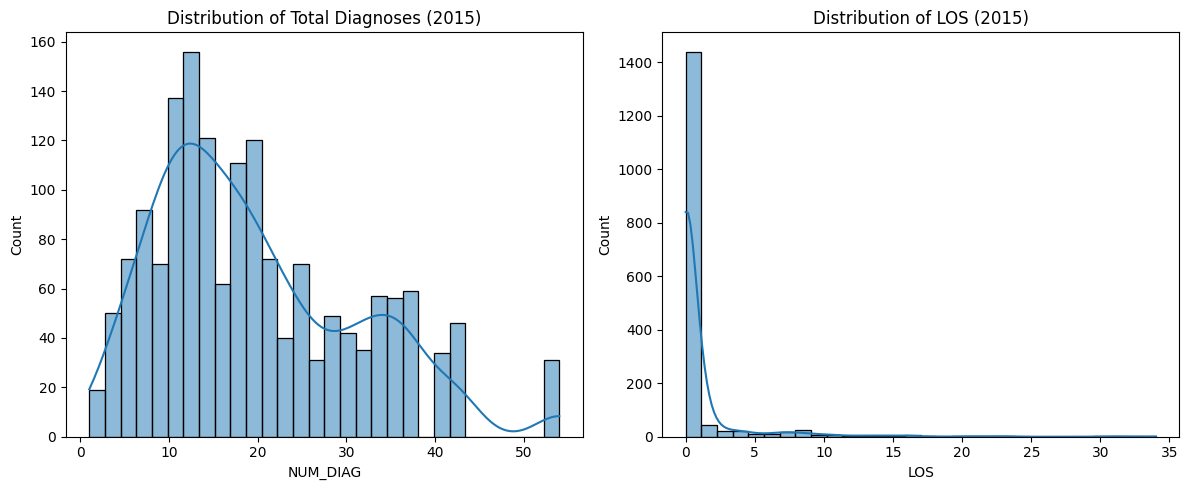

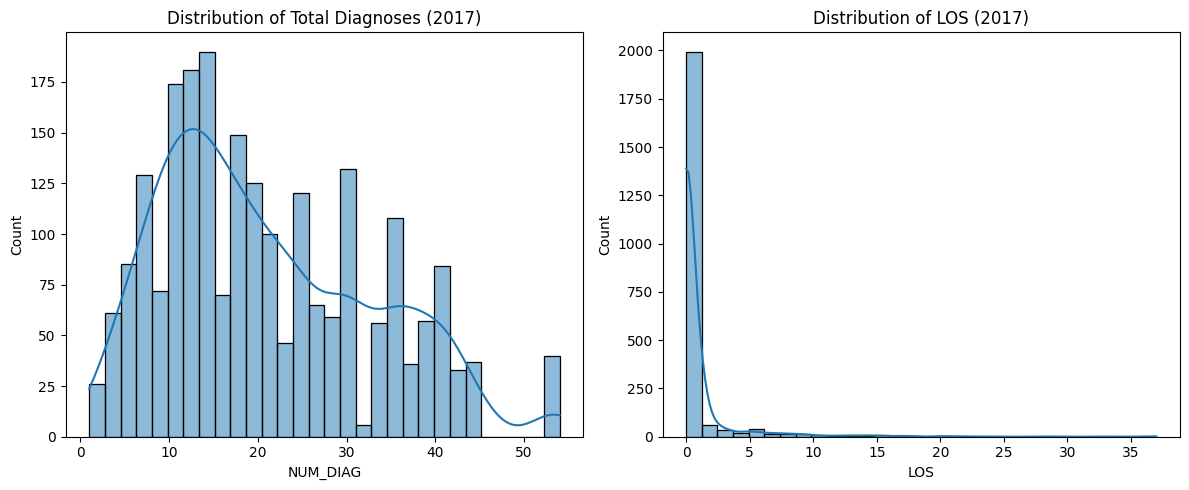

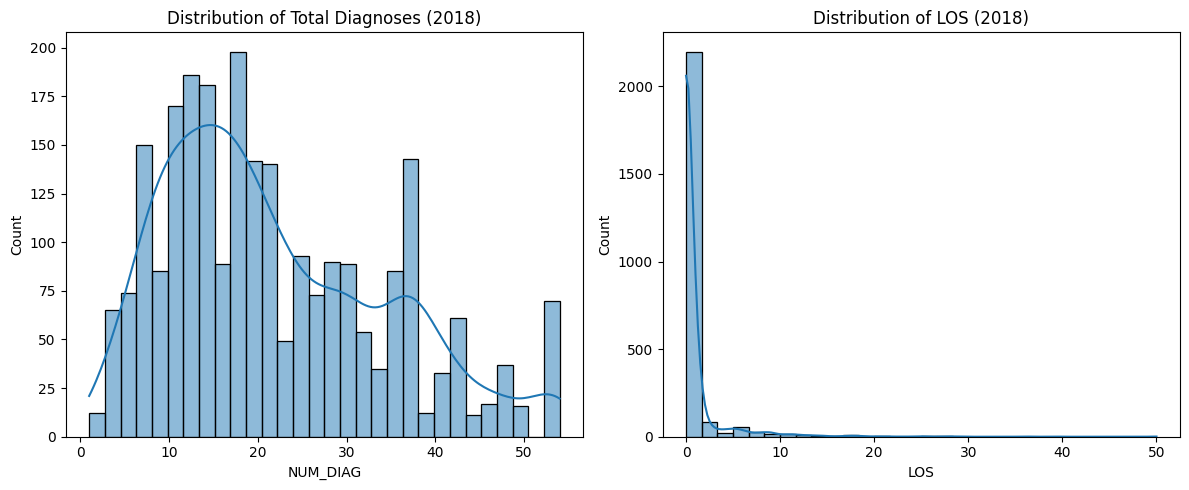

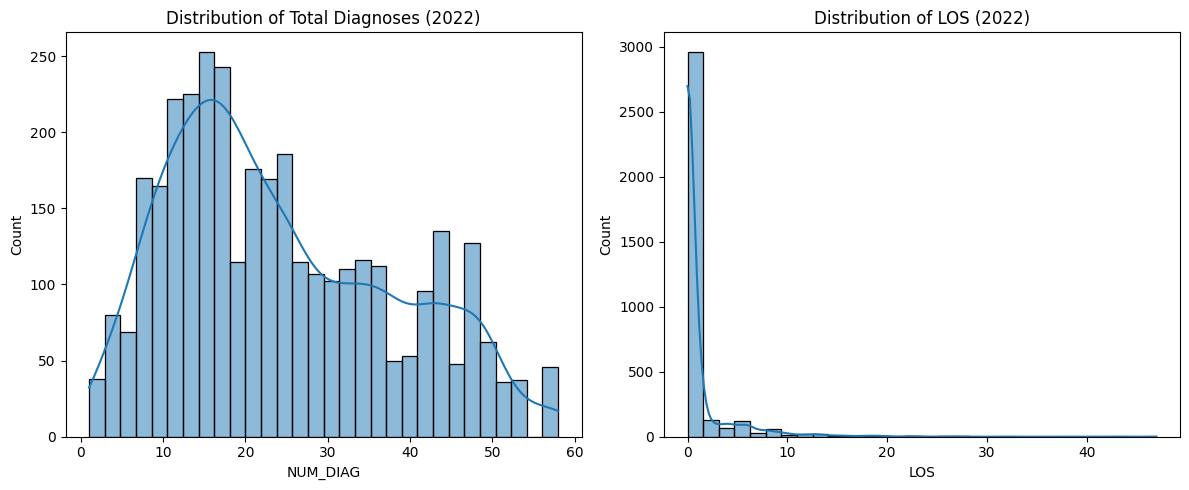

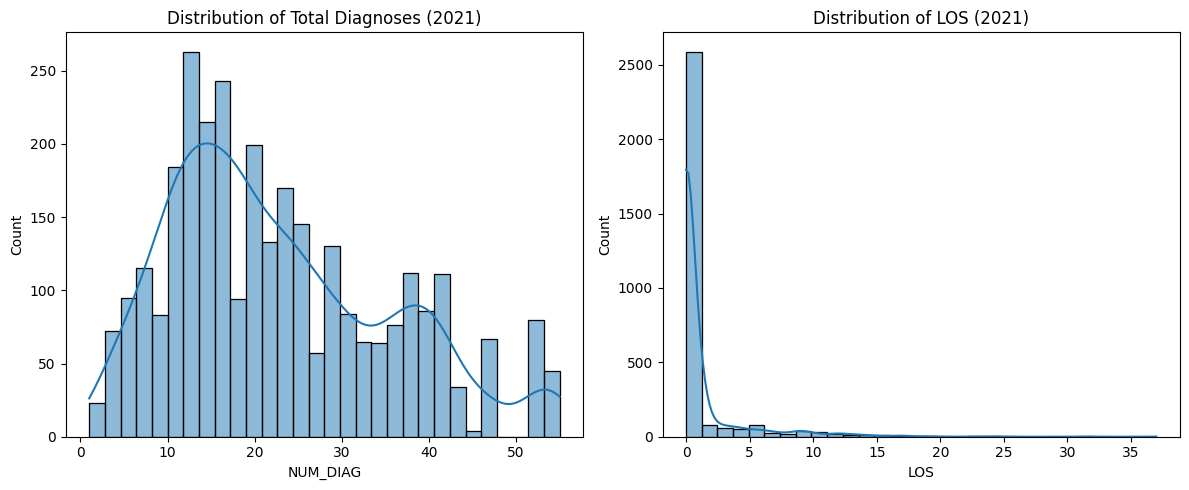

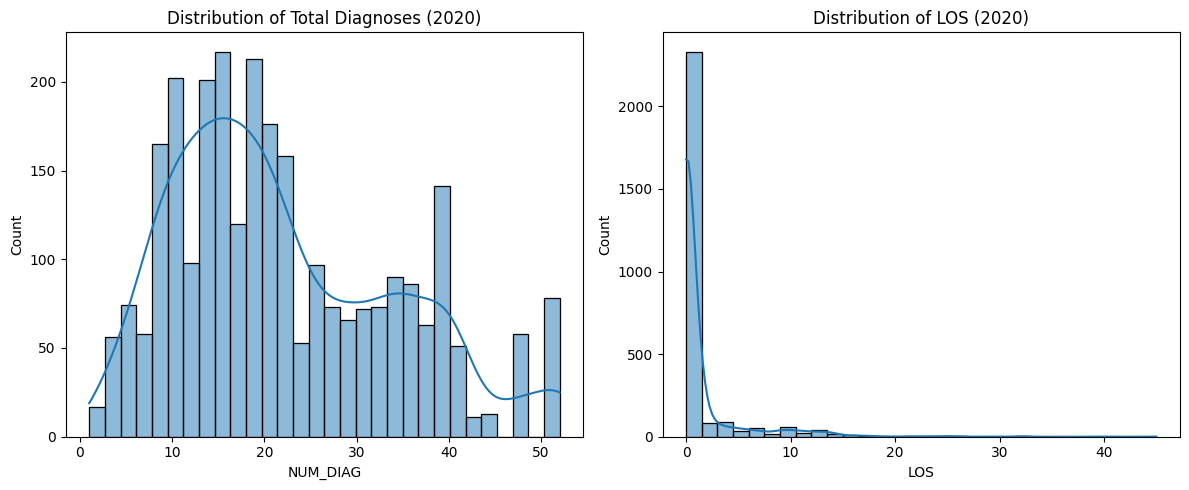

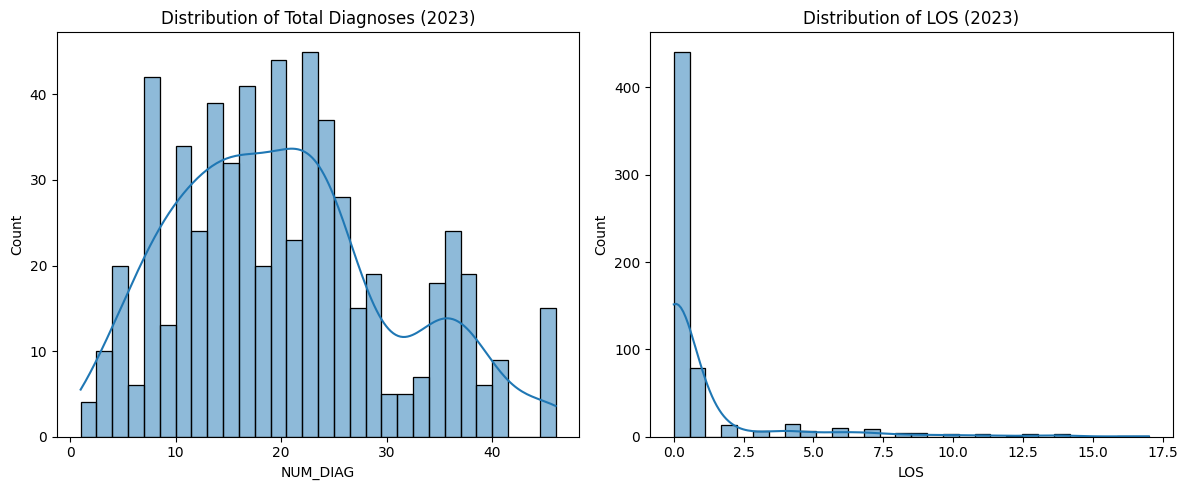

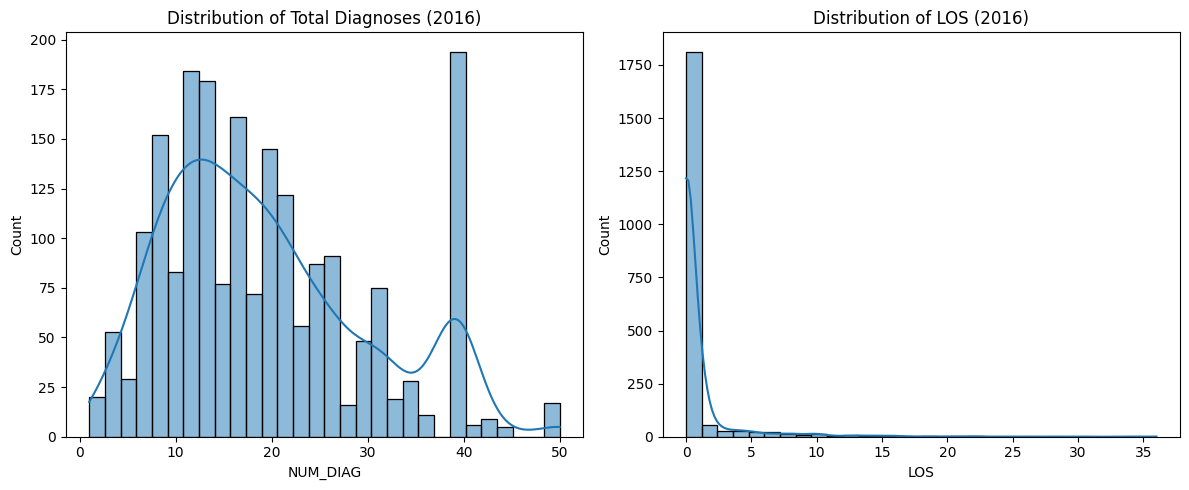

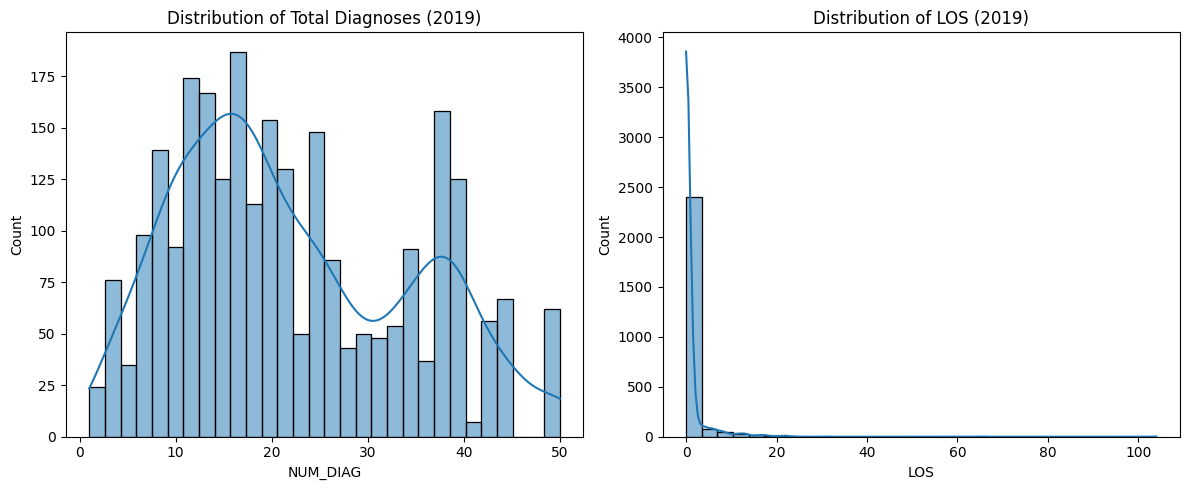

In [7]:
for year in main["YR"].unique():
    subset = main[main["YR"] == year]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot distribution of TOTAL_DIAGNOSES
    sns.histplot(subset["NUM_DIAG"], bins=30, kde=True, ax=axes[0])
    axes[0].set_title(f"Distribution of Total Diagnoses ({year})")
    
    # Plot distribution of LOS
    sns.histplot(subset["LOS"], bins=30, kde=True, ax=axes[1])
    axes[1].set_title(f"Distribution of LOS ({year})")
    
    plt.tight_layout()
    plt.show()

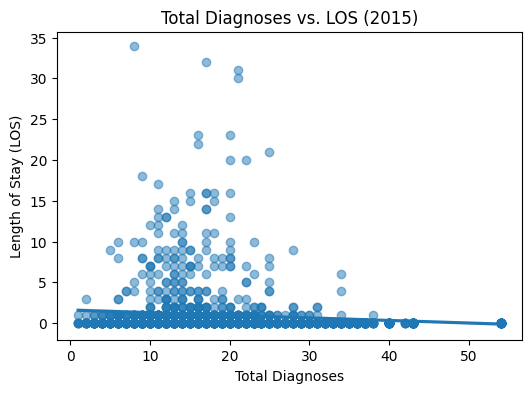

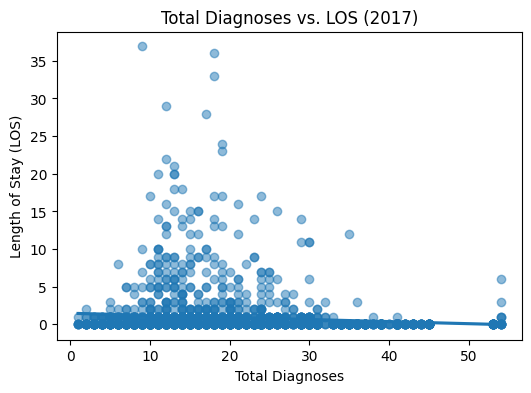

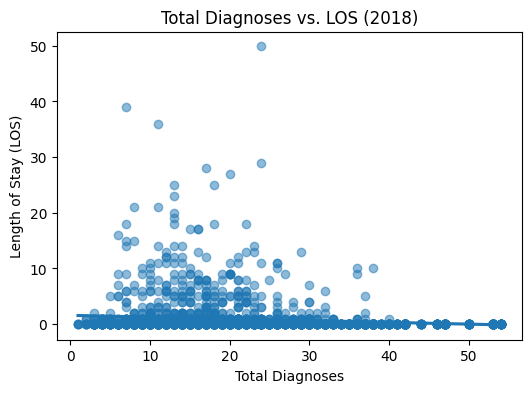

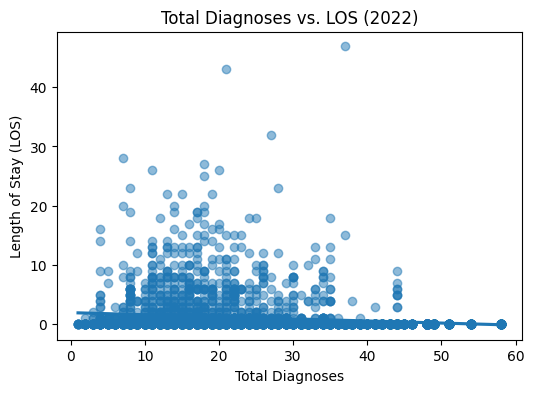

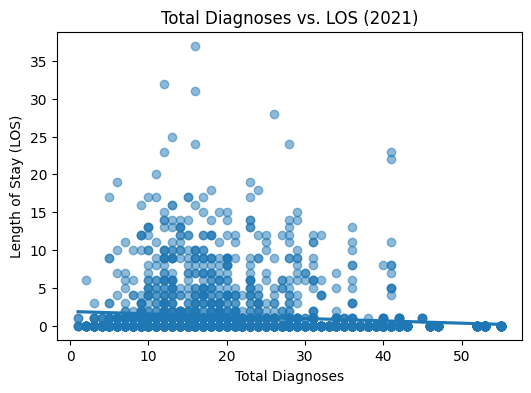

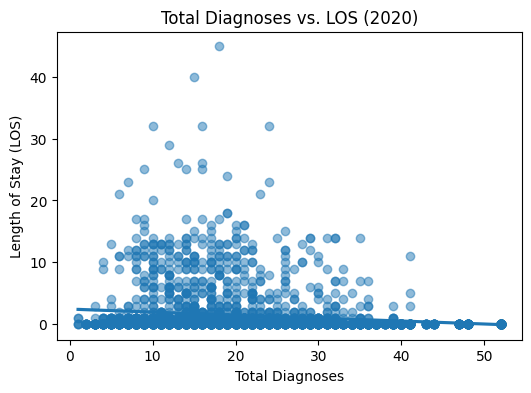

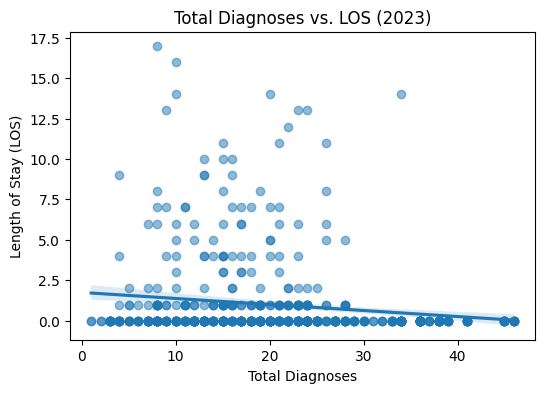

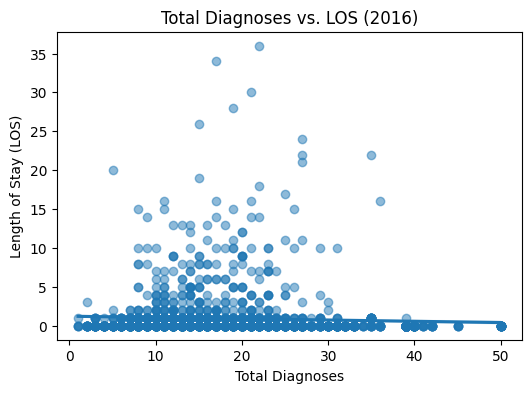

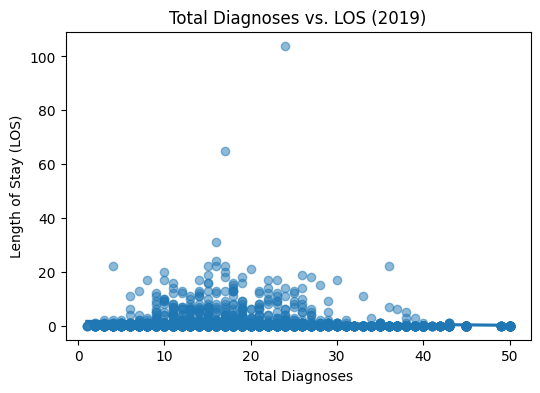

In [8]:
for year in main["YR"].unique():
    subset = main[main["YR"] == year]
    
    plt.figure(figsize=(6, 4))
    sns.regplot(x=subset["NUM_DIAG"], y=subset["LOS"], scatter_kws={"alpha": 0.5})
    plt.title(f"Total Diagnoses vs. LOS ({year})")
    plt.xlabel("Total Diagnoses")
    plt.ylabel("Length of Stay (LOS)")
    plt.show()

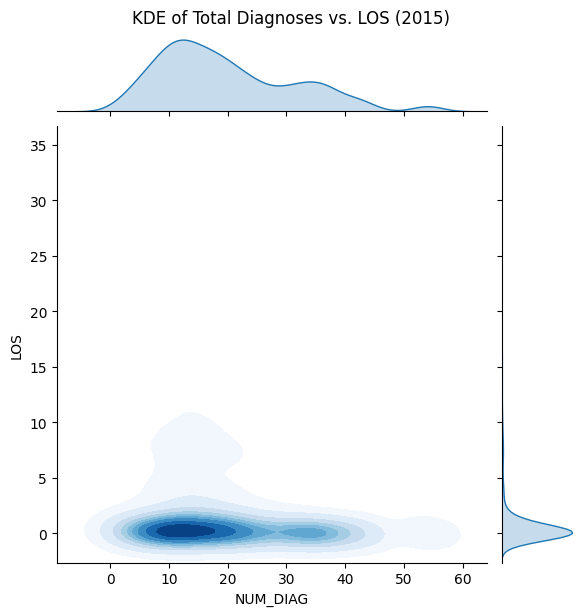

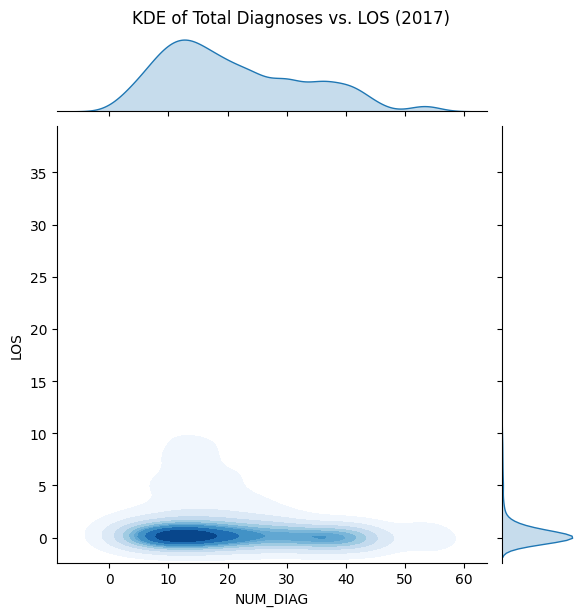

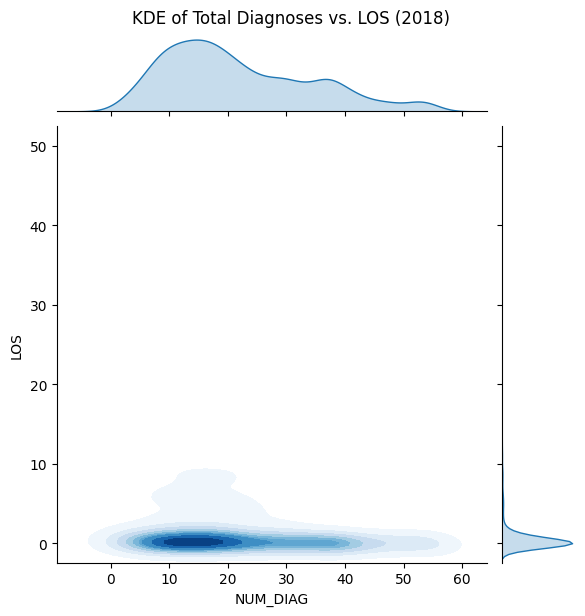

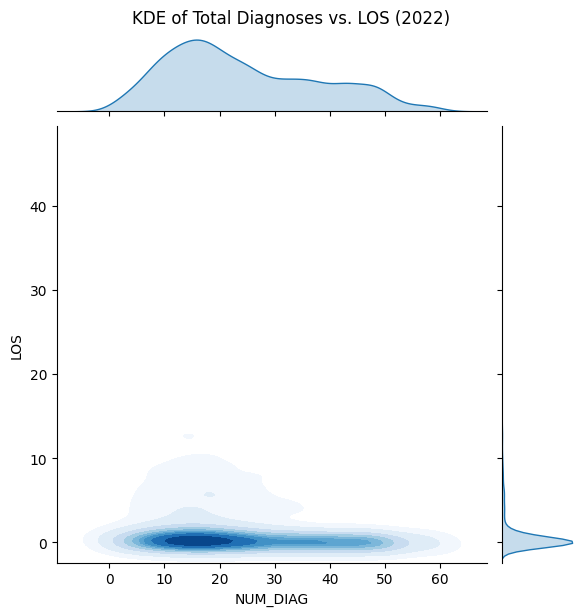

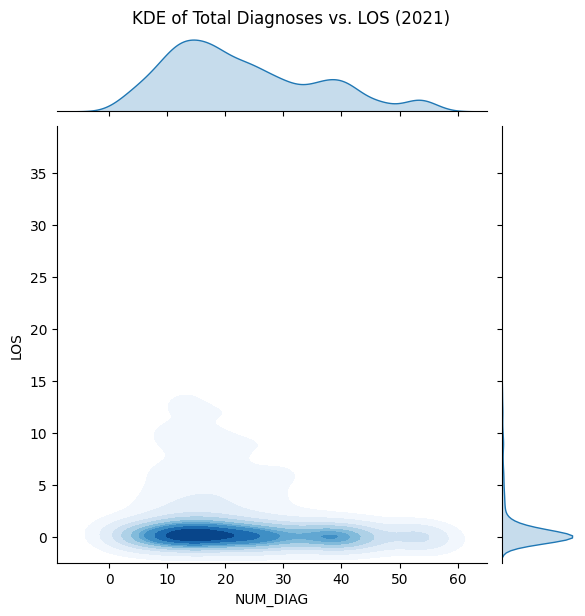

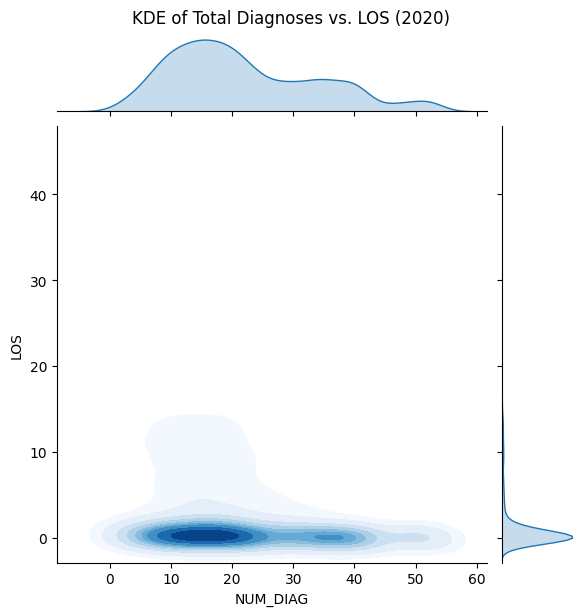

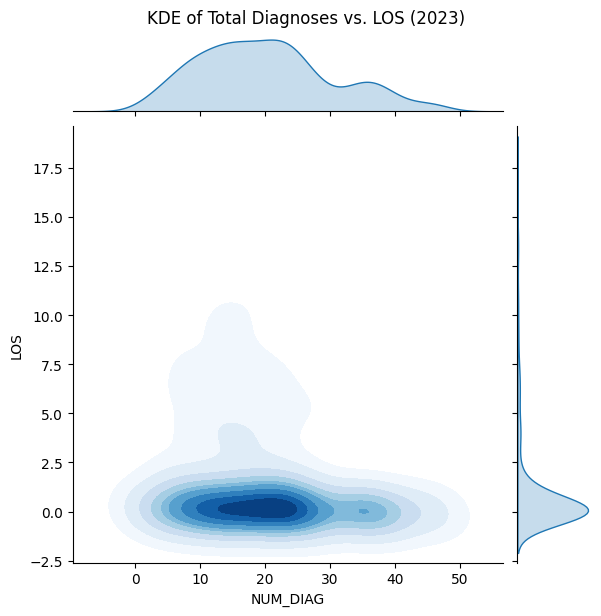

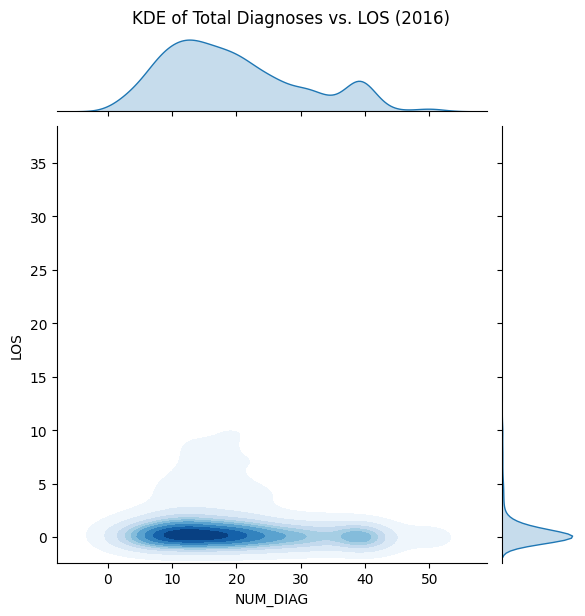

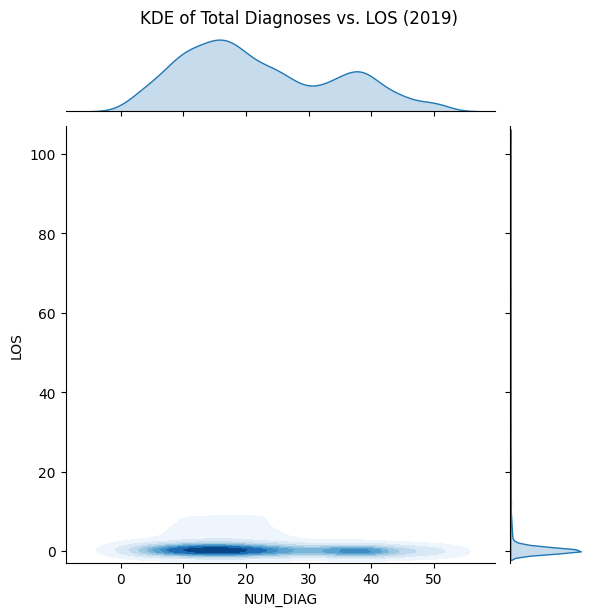

In [9]:
for year in main["YR"].unique():
    subset = main[main["YR"] == year]

    g = sns.jointplot(
        data=subset, x="NUM_DIAG", y="LOS",
        kind="kde", fill=True, cmap="Blues"
    )
    g.fig.suptitle(f"KDE of Total Diagnoses vs. LOS ({year})", y=1.02)
    plt.show()